<a href="https://colab.research.google.com/github/HHansi/Applied-AI-Course/blob/main/Time%20Series%20Analysis/Time_Series_Models_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Models (Part 2)

This notebook contains the practical examples and exercises for the Applied AI-Time Series Models. 

*Adapted from a tutorial by Dr Iain Rice. Modified by Hansi Hettiarachchi.*

Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import linalg
from scipy.fft import rfft, rfftfreq, irfft

# Kalman Filter

## The Basic Idea
[source](https://julia.quantecon.org/tools_and_techniques/kalman.html)

The Kalman filter has many applications in economics, but for now
let’s pretend that we are rocket scientists.

A missile has been launched from country Y and our mission is to track it.

Let $ x  \in \mathbb{R}^2 $ denote the current location of the missile—a
pair indicating latitude-longitude coordinates on a map.

At the present moment in time, the precise location $ x $ is unknown, but
we do have some beliefs about $ x $.

One way to summarize our knowledge is a point prediction $ \hat x $

- But what if the President wants to know the probability that the missile is currently over the Sea of Japan?  
- Then it is better to summarize our initial beliefs with a bivariate probability density $ p $  
  
  - $ \int_E p(x)dx $ indicates the probability that we attach to the missile being in region $ E $.  
  


The density $ p $ is called our *prior* for the random variable $ x $.

To keep things tractable in our example,  we  assume that our prior is Gaussian.

In particular, we take


<a id='equation-prior'></a>
$$
p = N(\hat x, \Sigma) \tag{1}
$$

where $ \hat x $ is the mean of the distribution and $ \Sigma $ is a
$ 2 \times 2 $ covariance matrix.  In our simulations, we will suppose that


<a id='equation-kalman-dhxs'></a>
$$
\hat x
= \left(
\begin{array}{c}
    0.2 \\
    -0.2
\end{array}
  \right),
\qquad
\Sigma
= \left(
\begin{array}{cc}
    0.4 & 0.3 \\
    0.3 & 0.45
\end{array}
  \right) \tag{2}
$$

This density $ p(x) $ is shown below as a contour map, with the center of the red ellipse being equal to $ \hat x $.

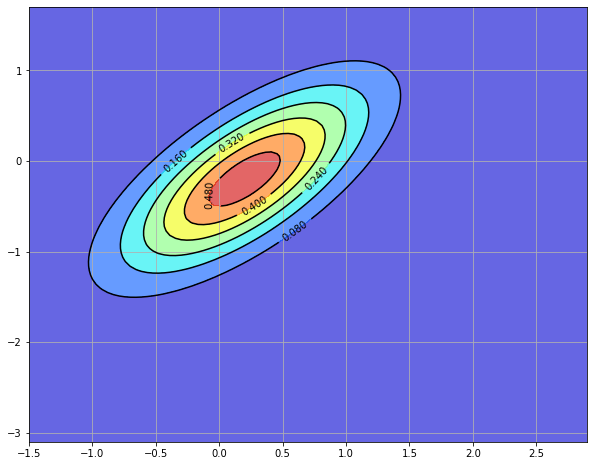

In [2]:
# Set up the Gaussian prior density p
Σ = [[0.4, 0.3], [0.3, 0.45]]
Σ = np.matrix(Σ)
x_hat = np.matrix([0.2, -0.2]).T
# Define the matrices G and R from the equation y = G x + N(0, R)
G = [[1, 0], [0, 1]]
G = np.matrix(G)
R = 0.5 * Σ
# The matrices A and Q
A = [[1.2, 0], [0, -0.2]]
A = np.matrix(A)
Q = 0.1 * Σ
# The observed value of y
y = np.matrix([2.3, -1.9]).T
# updated y
new_y = np.matrix([1.8, -0.6]).T

# Set up grid for plotting
x_grid = np.linspace(-1.5, 2.9, 100)
y_grid = np.linspace(-3.1, 1.7, 100)
X, Y = np.meshgrid(x_grid, y_grid)

def bivariate_normal(x, y, σ_x=1.0, σ_y=1.0, μ_x=0.0, μ_y=0.0, σ_xy=0.0):
    """
    Compute and return the probability density function of bivariate normal
    distribution of normal random variables x and y

    Parameters
    ----------
    x : array_like(float)
        Random variable

    y : array_like(float)
        Random variable

    σ_x : array_like(float)
          Standard deviation of random variable x

    σ_y : array_like(float)
          Standard deviation of random variable y

    μ_x : scalar(float)
          Mean value of random variable x

    μ_y : scalar(float)
          Mean value of random variable y

    σ_xy : array_like(float)
           Covariance of random variables x and y

    """

    x_μ = x - μ_x
    y_μ = y - μ_y

    ρ = σ_xy / (σ_x * σ_y)
    z = x_μ**2 / σ_x**2 + y_μ**2 / σ_y**2 - 2 * ρ * x_μ * y_μ / (σ_x * σ_y)
    denom = 2 * np.pi * σ_x * σ_y * np.sqrt(1 - ρ**2)
    return np.exp(-z / (2 * (1 - ρ**2))) / denom

def gen_gaussian_plot_vals(μ, C):
    "Z values for plotting the bivariate Gaussian N(μ, C)"
    m_x, m_y = float(μ[0]), float(μ[1])
    s_x, s_y = np.sqrt(C[0, 0]), np.sqrt(C[1, 1])
    s_xy = C[0, 1]
    return bivariate_normal(X, Y, s_x, s_y, m_x, m_y, s_xy)

# Plot the figure
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

Z = gen_gaussian_plot_vals(x_hat, Σ)
ax.contourf(X, Y, Z, 6, alpha=0.6, cmap=cm.jet)
cs = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs, inline=1, fontsize=10)

plt.show()

## The Filtering Step

We are now presented with some good news and some bad news.

The good news is that the missile has been located by our sensors, which report that the current location is $ y = (2.3, -1.9) $.

The next figure shows the original prior $ p(x) $ and the new reported
location $ y $

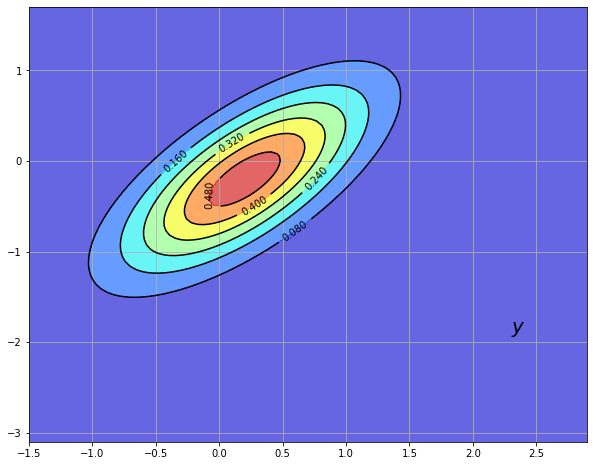

In [3]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

Z = gen_gaussian_plot_vals(x_hat, Σ)
ax.contourf(X, Y, Z, 6, alpha=0.6, cmap=cm.jet)
cs = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs, inline=1, fontsize=10)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

plt.show()

The bad news is that our sensors are imprecise.

In particular, we should interpret the output of our sensor not as
$ y=x $, but rather as


<a id='equation-kl-measurement-model'></a>
$$
y = G x + v, \quad \text{where} \quad v \sim N(0, R) \tag{3}
$$

Here $ G $ and $ R $ are $ 2 \times 2 $ matrices with $ R $
positive definite.  Both are assumed known, and the noise term $ v $ is assumed
to be independent of $ x $.

How then should we combine our prior $ p(x) = N(\hat x, \Sigma) $ and this
new information $ y $ to improve our understanding of the location of the
missile?

As you may have guessed, the answer is to use Bayes’ theorem, which tells
us to  update our prior $ p(x) $ to $ p(x \,|\, y) $ via

$$
p(x \,|\, y) = \frac{p(y \,|\, x) \, p(x)} {p(y)}
$$

where $ p(y) = \int p(y \,|\, x) \, p(x) dx $.

In solving for $ p(x \,|\, y) $, we observe that

- $ p(x) = N(\hat x, \Sigma) $.  
- In view of [(3)](#equation-kl-measurement-model), the conditional density $ p(y \,|\, x) $ is $ N(Gx, R) $.  
- $ p(y) $ does not depend on $ x $, and enters into the calculations only as a normalizing constant.  


Because we are in a linear and Gaussian framework, the updated density can be computed by calculating population linear regressions.

In particular, the solution is known <sup><a href=#f1 id=f1-link>[1]</a></sup> to be

$$
p(x \,|\, y) = N(\hat x^F, \Sigma^F)
$$

where


<a id='equation-kl-filter-exp'></a>
$$
\hat x^F := \hat x + \Sigma G' (G \Sigma G' + R)^{-1}(y - G \hat x)
\quad \text{and} \quad
\Sigma^F := \Sigma - \Sigma G' (G \Sigma G' + R)^{-1} G \Sigma \tag{4}
$$

Here  $ \Sigma G' (G \Sigma G' + R)^{-1} $ is the matrix of population regression coefficients of the hidden object $ x - \hat x $ on the surprise $ y - G \hat x $.

This new density $ p(x \,|\, y) = N(\hat x^F, \Sigma^F) $ is shown in the next figure via contour lines and the color map.

The original density is left in as contour lines for comparison

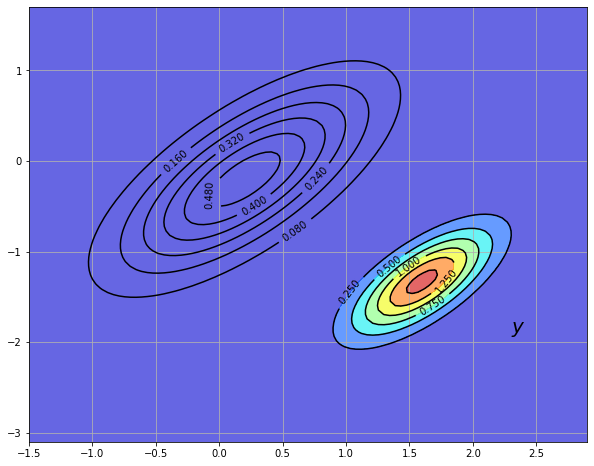

In [4]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

Z = gen_gaussian_plot_vals(x_hat, Σ)
cs1 = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs1, inline=1, fontsize=10)
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ
new_Z = gen_gaussian_plot_vals(x_hat_F, Σ_F)
cs2 = ax.contour(X, Y, new_Z, 6, colors="black")
ax.clabel(cs2, inline=1, fontsize=10)
ax.contourf(X, Y, new_Z, 6, alpha=0.6, cmap=cm.jet)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

plt.show()

## The Forecast Step

What have we achieved so far?

We have obtained probabilities for the current location of the state (missile) given prior and current information.

This is called “filtering” rather than forecasting because we are filtering
out noise rather than looking into the future.

- $ p(x \,|\, y) = N(\hat x^F, \Sigma^F) $ is called the *filtering distribution*  


But now let’s suppose that we are given another task: to predict the location of the missile after one unit of time (whatever that may be) has elapsed.

To do this we need a model of how the state evolves.

Let’s suppose that we have one, and that it’s linear and Gaussian. In particular,


<a id='equation-kl-xdynam'></a>
$$
x_{t+1} = A x_t + w_{t+1}, \quad \text{where} \quad w_t \sim N(0, Q) \tag{5}
$$

Our aim is to combine this law of motion and our current distribution $ p(x \,|\, y) = N(\hat x^F, \Sigma^F) $ to come up with a new *predictive* distribution for the location in one unit of time.

In view of [(5)](#equation-kl-xdynam), all we have to do is introduce a random vector $ x^F \sim N(\hat x^F, \Sigma^F) $ and work out the distribution of $ A x^F + w $ where $ w $ is independent of $ x^F $ and has distribution $ N(0, Q) $.

Since linear combinations of Gaussians are Gaussian, $ A x^F + w $ is Gaussian.

Elementary calculations and the expressions in [(4)](#equation-kl-filter-exp) tell us that

$$
\mathbb{E} [A x^F + w]
= A \mathbb{E} x^F + \mathbb{E} w
= A \hat x^F
= A \hat x + A \Sigma G' (G \Sigma G' + R)^{-1}(y - G \hat x)
$$

and

$$
\operatorname{Var} [A x^F + w]
= A \operatorname{Var}[x^F] A' + Q
= A \Sigma^F A' + Q
= A \Sigma A' - A \Sigma G' (G \Sigma G' + R)^{-1} G \Sigma A' + Q
$$

The matrix $ A \Sigma G' (G \Sigma G' + R)^{-1} $ is often written as
$ K_{\Sigma} $ and called the *Kalman gain*.

- The subscript $ \Sigma $ has been added to remind us that  $ K_{\Sigma} $ depends on $ \Sigma $, but not $ y $ or $ \hat x $.  


Using this notation, we can summarize our results as follows.

Our updated prediction is the density $ N(\hat x_{new}, \Sigma_{new}) $ where


<a id='equation-kl-mlom0'></a>
$$
\begin{aligned}
    \hat x_{new} &:= A \hat x + K_{\Sigma} (y - G \hat x) \\
    \Sigma_{new} &:= A \Sigma A' - K_{\Sigma} G \Sigma A' + Q \nonumber
\end{aligned} \tag{6}
$$

- The density $ p_{new}(x) = N(\hat x_{new}, \Sigma_{new}) $ is called the *predictive distribution*  


The predictive distribution is the new density shown in the following figure, where
the update has used parameters.

$$
A
= \left(
\begin{array}{cc}
    1.2 & 0.0 \\
    0.0 & -0.2
\end{array}
  \right),
  \qquad
Q = 0.3 * \Sigma
$$

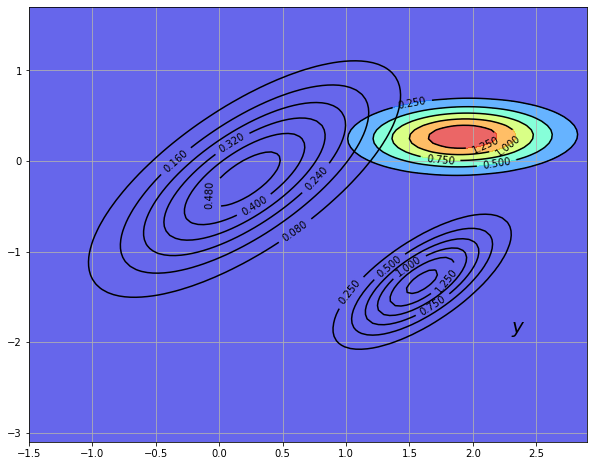

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

# Density 1
Z = gen_gaussian_plot_vals(x_hat, Σ)
cs1 = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs1, inline=1, fontsize=10)

# Density 2
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ
Z_F = gen_gaussian_plot_vals(x_hat_F, Σ_F)
cs2 = ax.contour(X, Y, Z_F, 6, colors="black")
ax.clabel(cs2, inline=1, fontsize=10)

# Density 3
new_x_hat = A * x_hat_F
new_Σ = A * Σ_F * A.T + Q
new_Z = gen_gaussian_plot_vals(new_x_hat, new_Σ)
cs3 = ax.contour(X, Y, new_Z, 6, colors="black")
ax.clabel(cs3, inline=1, fontsize=10)
ax.contourf(X, Y, new_Z, 6, alpha=0.6, cmap=cm.jet)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

plt.show()

Now we get another measurement with y now being at (1.8,-0.6) so we need to do another update and prediction step.

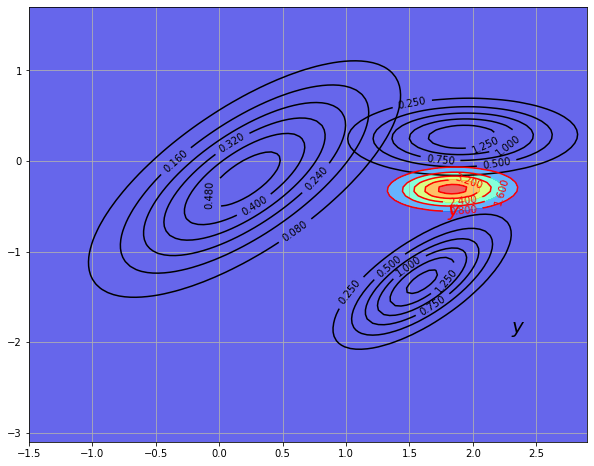

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

# Density 1
Z = gen_gaussian_plot_vals(x_hat, Σ)
cs1 = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs1, inline=1, fontsize=10)

# Density 2
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ
Z_F = gen_gaussian_plot_vals(x_hat_F, Σ_F)
cs2 = ax.contour(X, Y, Z_F, 6, colors="black")
ax.clabel(cs2, inline=1, fontsize=10)

# Density 3
new_x_hat = A * x_hat_F
new_Σ = A * Σ_F * A.T + Q
new_Z = gen_gaussian_plot_vals(new_x_hat, new_Σ)
cs3 = ax.contour(X, Y, new_Z, 6, colors="black")
ax.clabel(cs3, inline=1, fontsize=10)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

# Density 4
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
new_x_hat_F = new_x_hat + M * (new_y - G * new_x_hat)
new_Σ_F = new_Σ - M * G * new_Σ
new_Z_F = gen_gaussian_plot_vals(new_x_hat_F, new_Σ_F)
cs4 = ax.contour(X, Y, new_Z_F, 6, colors="red")
ax.clabel(cs4, inline=1, fontsize=10)
ax.contourf(X, Y, new_Z_F, 6, alpha=0.6, cmap=cm.jet)
ax.text(float(new_y[0]), float(new_y[1]), "$y$", fontsize=20, color="red")

plt.show()

The filtered update is much closer to the new y measurement (shown in red). We just need to take account of our expected dynamics to predict where it's going next.

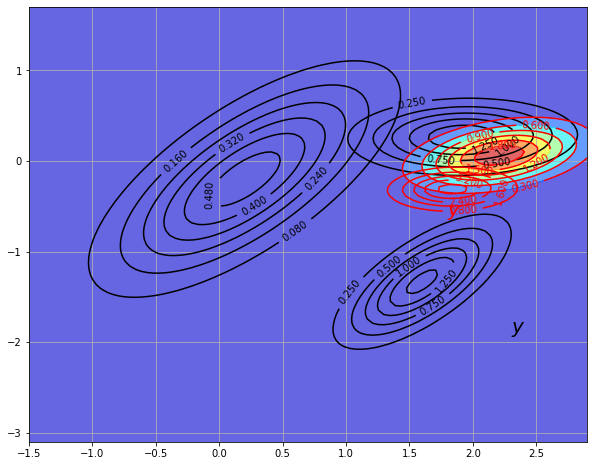

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

# Density 1
Z = gen_gaussian_plot_vals(x_hat, Σ)
cs1 = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs1, inline=1, fontsize=10)

# Density 2
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ
Z_F = gen_gaussian_plot_vals(x_hat_F, Σ_F)
cs2 = ax.contour(X, Y, Z_F, 6, colors="black")
ax.clabel(cs2, inline=1, fontsize=10)

# Density 3
new_x_hat = A * x_hat_F
new_Σ = A * Σ_F * A.T + Q
new_Z = gen_gaussian_plot_vals(new_x_hat, new_Σ)
cs3 = ax.contour(X, Y, new_Z, 6, colors="black")
ax.clabel(cs3, inline=1, fontsize=10)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

# Density 4
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
new_x_hat_F = new_x_hat + M * (new_y - G * new_x_hat)
new_Σ_F = new_Σ - M * G * new_Σ
new_Z_F = gen_gaussian_plot_vals(new_x_hat_F, new_Σ_F)
cs4 = ax.contour(X, Y, new_Z_F, 6, colors="red")
ax.clabel(cs4, inline=1, fontsize=10)
ax.text(float(new_y[0]), float(new_y[1]), "$y$", fontsize=20, color="red")

# Density 5
new_new_x_hat = A * new_x_hat_F
new_new_Σ = A * new_Σ_F * A.T + Q
new_new_Z = gen_gaussian_plot_vals(new_new_x_hat, new_new_Σ)
cs3 = ax.contour(X, Y, new_new_Z, 6, colors="red")
ax.clabel(cs3, inline=1, fontsize=10)
ax.contourf(X, Y, new_new_Z, 6, alpha=0.6, cmap=cm.jet)

plt.show()

# Fourier Analysis

In Fouries Analysis, we transform a time domain representation (function of time) to a frequency domain representation (function of frequency) to analyse the characteristics in data such as periodicity.

Tutorials:
* [Fourier Transforms (scipy.fft)](https://docs.scipy.org/doc/scipy/tutorial/fft.html)
* [Python Operators](https://www.w3schools.com/python/python_operators.asp)

(200,)
(200,)


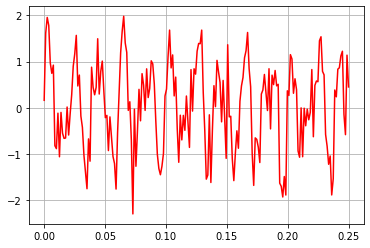

In [8]:
# Define a sample time series
N = 200 # number of sample points
T = 1.0 / 800.0 # sample spacing
x = np.linspace(0.0, N*T, N)
print(x.shape)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x) + 0.5*np.random.normal(size=(N))
print(y.shape)


# plot series
plt.plot(x,y,'r')
plt.grid()
plt.show()

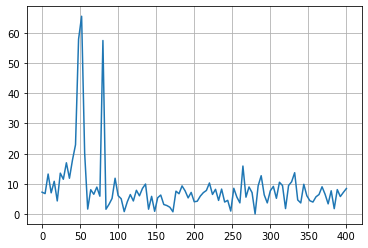

In [9]:
# Fourier transform
yf   = rfft(y)
xf   = rfftfreq(N,T)

# plot series
plt.plot(xf,np.abs(yf))
plt.grid()
plt.show()

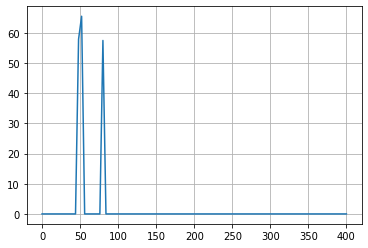

In [10]:
# remove noise frequencies
yf_abs      = np.abs(yf) 
indices     = yf_abs>30   # filter out those values under 30
yf_clean    = indices * yf # noise frequency will be set to 0

# plot series
plt.plot(xf,np.abs(yf_clean))
plt.grid()
plt.show()

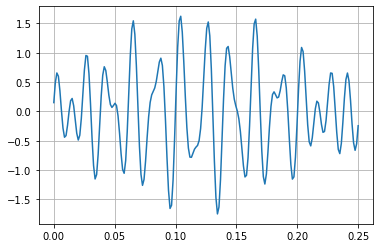

In [11]:
# inverse back to time domain
y_clean = irfft(yf_clean)

# plot series
plt.plot(x,y_clean)
plt.grid()
plt.show()

# Independent Component Analysis

Tutorial - [Independent Component Analysis (ICA) In Python](https://towardsdatascience.com/independent-component-analysis-ica-in-python-a0ef0db0955e)

# Changepoints

Tutorial - [Detecting the Change Points in a Time Series](https://medium.com/dataman-in-ai/finding-the-change-points-in-a-time-series-95a308207012)